## Poisonous mushrooms - PCA, KMeans and Gaussian Mixture Models


This is a project based on a classic dataset on poisonous mushrooms.  It contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature set is binarized, as all the observations are categorical.

This project is based on a homework assignment for the MIDS (Masters in Data Science) program at The University of California, Berkeley.

I'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once I've projected the data to 2 dimensions, I'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, I'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.


In [1]:
%matplotlib inline

import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

warnings.filterwarnings("ignore", category=UserWarning) 

Load feature names.

In [2]:
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)
print 'Here are all 126 feature names: \n'
for i in range(126):
    print feature_names[i]


Loaded feature names: 126
Here are all 126 feature names: 

cap-shape=bell
cap-shape=conical
cap-shape=convex
cap-shape=flat
cap-shape=knobbed
cap-shape=sunken
cap-surface=fibrous
cap-surface=grooves
cap-surface=scaly
cap-surface=smooth
cap-color=brown
cap-color=buff
cap-color=cinnamon
cap-color=gray
cap-color=green
cap-color=pink
cap-color=purple
cap-color=red
cap-color=white
cap-color=yellow
bruises?=bruises
bruises?=no
odor=almond
odor=anise
odor=creosote
odor=fishy
odor=foul
odor=musty
odor=none
odor=pungent
odor=spicy
gill-attachment=attached
gill-attachment=descending
gill-attachment=free
gill-attachment=notched
gill-spacing=close
gill-spacing=crowded
gill-spacing=distant
gill-size=broad
gill-size=narrow
gill-color=black
gill-color=brown
gill-color=buff
gill-color=chocolate
gill-color=gray
gill-color=green
gill-color=orange
gill-color=pink
gill-color=purple
gill-color=red
gill-color=white
gill-color=yellow
stalk-shape=enlarging
stalk-shape=tapering
stalk-root=bulbous
stalk-root=c

Load data. The data is sparse in the input file, but there aren't too many features, so I'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, 
print test_data.shape

(7000L, 126L) (1124L, 126L)


First we run Principal Components Analysis on the data and show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

k 	 explained variance ratio
1 	 16.40%
2 	 13.32%
3 	 10.17%
4 	 7.06%
5 	 3.87%
6 	 3.68%
7 	 3.13%
8 	 2.73%
9 	 2.62%
10 	 2.23%
11 	 2.05%
12 	 1.87%
13 	 1.73%
14 	 1.68%
15 	 1.52%
16 	 1.51%
17 	 1.43%
18 	 1.41%
19 	 1.33%
20 	 1.15%
21 	 1.07%
22 	 1.07%
23 	 1.04%
24 	 0.99%
25 	 0.91%
26 	 0.87%
27 	 0.80%
28 	 0.78%
29 	 0.74%
30 	 0.70%
31 	 0.64%
32 	 0.61%
33 	 0.57%
34 	 0.53%
35 	 0.53%
36 	 0.50%
37 	 0.50%
38 	 0.46%
39 	 0.45%
40 	 0.44%
41 	 0.42%
42 	 0.40%
43 	 0.37%
44 	 0.36%
45 	 0.34%
46 	 0.30%
47 	 0.27%
48 	 0.24%
49 	 0.22%
50 	 0.20%


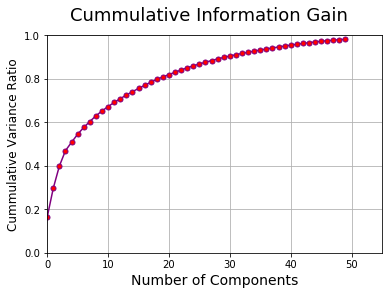

In [4]:
def P1():

    # PCA with 50 components
    n_comp = 50
    pca = PCA(n_components = n_comp)
    pca.fit(train_data)
    pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
    
    # Plot the Information Gain graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(pca_cumsum, color = 'purple', marker = 'o', ms = 5, mfc = 'red')
    fig.suptitle('Cummulative Information Gain', fontsize=18)
    plt.xlabel('Number of Components', fontsize=14)
    plt.ylabel('Cummulative Variance Ratio', fontsize=12)
    plt.grid(True)
    ax.set_xlim([0,55])
    ax.set_ylim([0.0,1.0])
    
    print 'k \t explained variance ratio'

    for k in range(1,51):    
        print "%d \t %s" % (k, '{0:.2f}%'.format(pca.explained_variance_ratio_[k-1] * 100))


P1()

Nearly all of the variance is explained in the first 50 PCA components.  For the sake of visualization and understanding, we'll use just the first 2 components, which together capture about 30% of the variation in the data.

PCA can also be very useful for visualizing data. Here is the data projected down to 2 dimensions. The positive (poisonous) cases are in blue and the negative (non-poisonous) are in red.

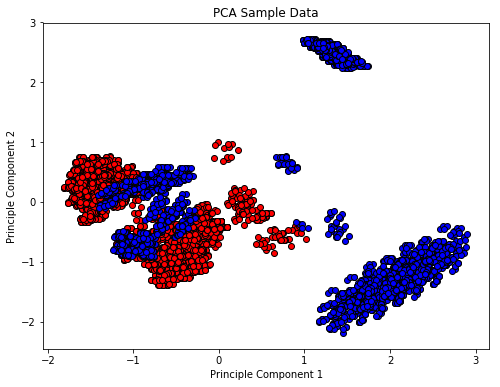

In [5]:
def P2():

    n_comp = 2
    pca_mod = PCA(n_components = 2)
    train_data_transformed = pca_mod.fit_transform(train_data)

    plt.figure(figsize=(8, 6))
    p = plt.subplot(1, 1, 1)
    p.scatter(train_data_transformed[train_labels == 0, 0], train_data_transformed[train_labels == 0, 1],
              edgecolors='black',color='red',marker='o')
    p.scatter(train_data_transformed[train_labels == 1, 0], train_data_transformed[train_labels == 1, 1],
              edgecolors='black',color='blue',marker='o')
    plt.title("PCA Sample Data")
    plt.xlabel("Principle Component 1")
    plt.ylabel("Principle Component 2")

P2()

KMeans clustering is one of the simplist ways to group data.  The poitns are split into k clusters, which each point belonging to the cluster with the closest center of mass.   It's best used when the data are well clustered into defined (in the best case scenario spherical in n-space) groups.  Below I show 16 different plots on the 2 dimensional data, each one representing the KMeans partitioning for k in [1,16].

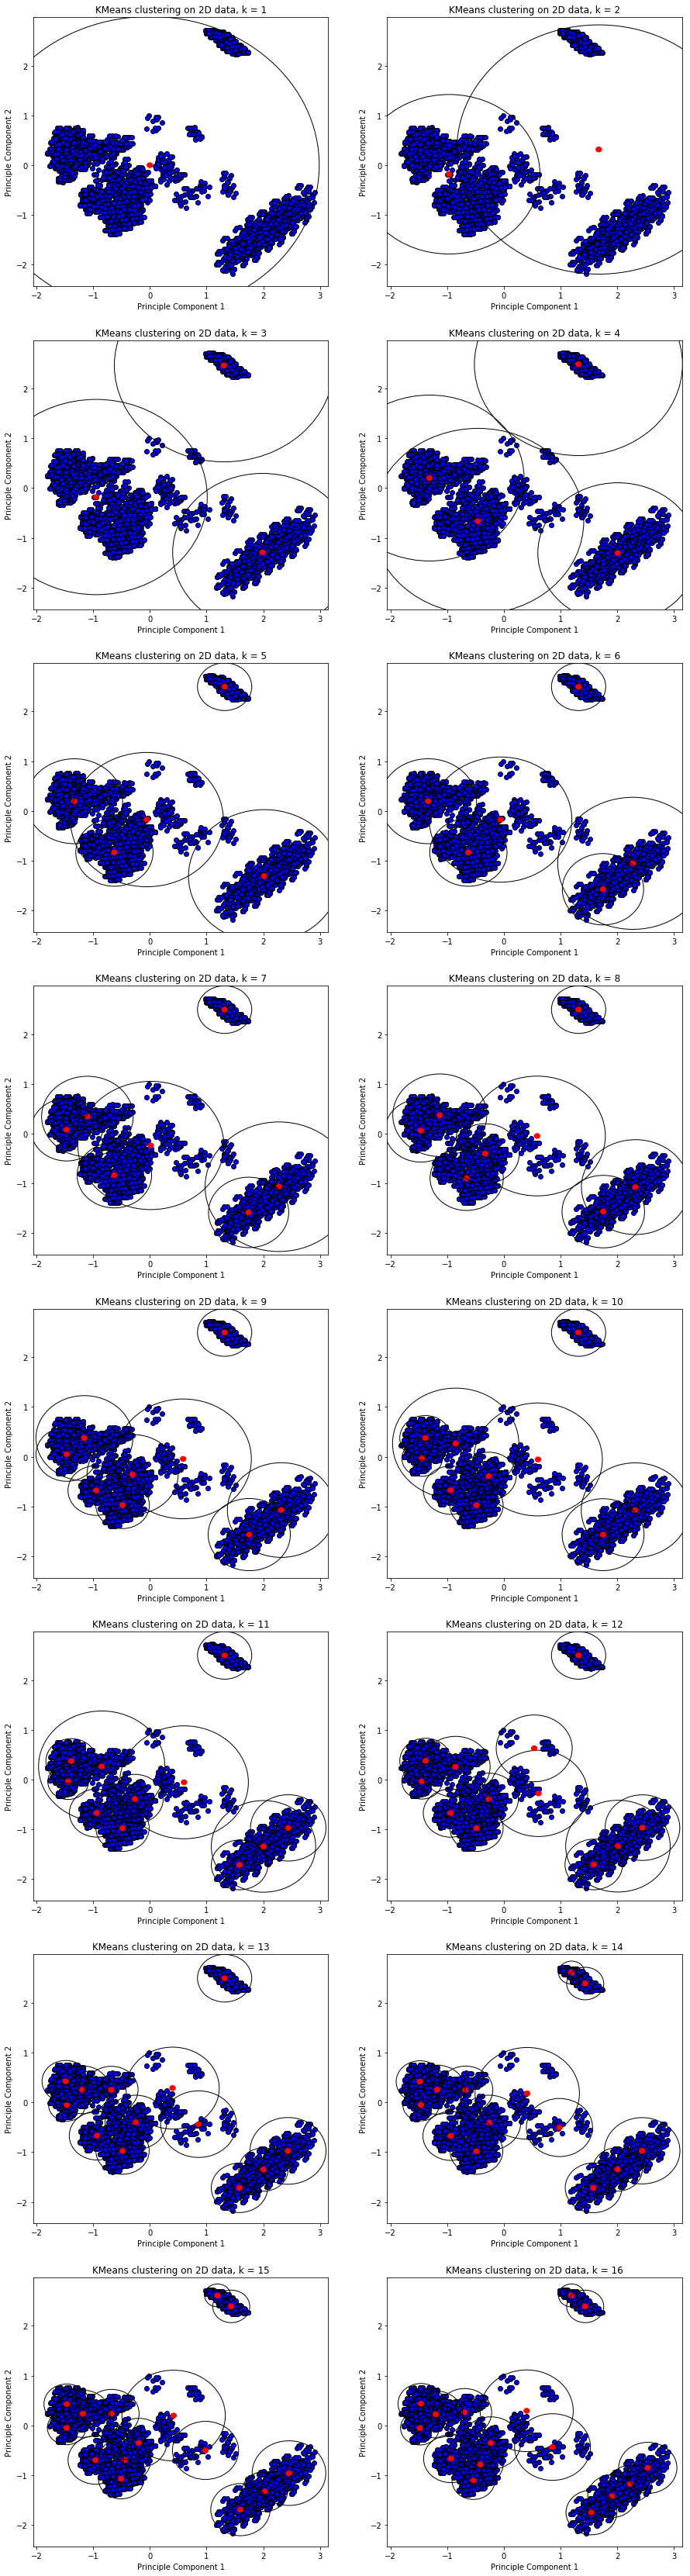

In [6]:
def P3():

    plt.figure(figsize=(15, 60))

    # Project the data to 2D
    n_comp = 2
    pca_mod = PCA(n_components = 2)
    train_data_transformed = pca_mod.fit_transform(train_data)

    for i in range(16):
        
        # Set up the plot
        ax = plt.subplot(8, 2, i+1)
        
        # Set up k-means 
        km = KMeans(n_clusters=i+1, init='k-means++')
        
        # Train the clustering algorithm
        clstrs = km.fit(train_data_transformed)

        # Find the center of each cluster, and the distances to each point
        centers = [(clstrs.cluster_centers_[j,0],clstrs.cluster_centers_[j,1]) for j in range(i+1)]
        dists = km.transform(train_data_transformed)

        # The scatterplot
        ax.scatter(train_data_transformed[:, 0], train_data_transformed[:, 1], edgecolors='black',color='blue',marker='o')
        plt.title('KMeans clustering on 2D data, k = %i' %(i+1)) 
        plt.xlabel("Principle Component 1")
        plt.ylabel("Principle Component 2")
    
        # Add the cluster centers and a circle encompassing all points in the cluster
        for j in range(i+1):
            circle = plt.Circle(centers[j], np.max(dists[clstrs.labels_ == j,j]),edgecolor='black',fill=False)
            my_center = plt.Circle(centers[j], 0.05, color='red')
            ax.add_artist(circle)
            ax.add_artist(my_center)



P3()

Gaussian Mixture Models assume that the data points are random draws from a single or multiple Gaussian population models, and optimize the parameters of an underlying population models to maximize the liklihood of the data (in fact, the algorithm uses expactation maximization instead of maximum likelihood/gradient descent, but that's a little in the weeds for this demonstration).  

Here I fit a Gaussian Mixture Model for the positive examples in the 2d projected data.  I also plot estimated density contours (negative log likelihoodof points drawn from the underlying population model as estimated by the algorithm):  I vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

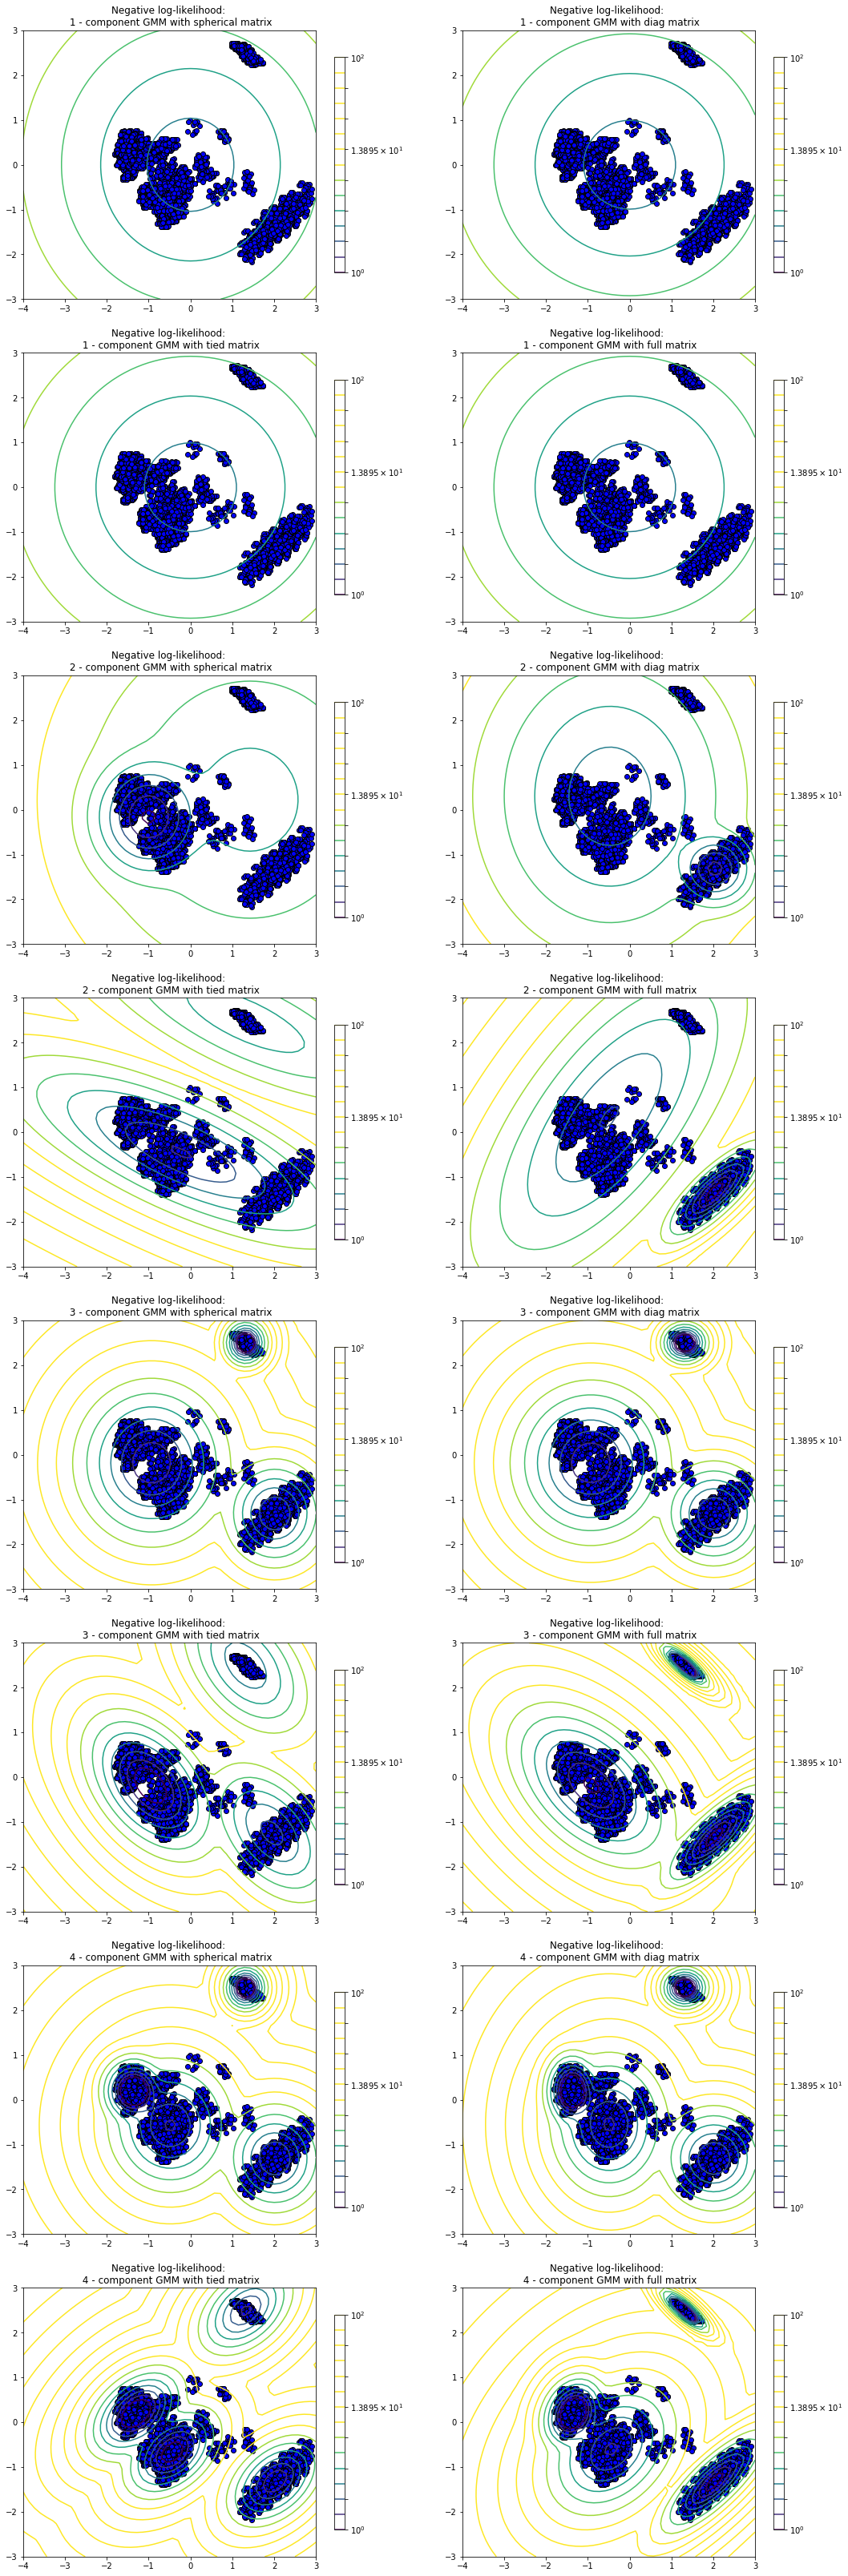

In [19]:
def P4():

    plt.figure(figsize=(18, 58))
    components = [1,2,3,4]
    covariance = ["spherical","diag","tied","full"]
    
    n_comp = 2
    pca_mod = PCA(n_components = 2)
    train_data_transformed = pca_mod.fit_transform(train_data)

    for i in range(4):
        for j in range(4):

            # Set up the plot
            cnt = 4*i + j + 1
            ax = plt.subplot(8, 2, cnt)

            # fit a Gaussian Mixture Model
            clf = GaussianMixture(n_components=components[i], covariance_type=covariance[j])
            clf.fit(train_data_transformed)

            # display predicted scores by the model as a contour plot
            # This plotting code borrowed from:
            # http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py.
            x = np.linspace(-4., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=10.0),
                             levels=np.logspace(0, 2, 15))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            ax.scatter(train_data_transformed[:, 0], train_data_transformed[:, 1], edgecolors='black',color='blue',marker='o')

            plt.title('Negative log-likelihood: \n %i - component GMM with %s matrix' %(components[i],covariance[j]))

P4()

Finally, I do inference on the data (poisonous or not poisonous).  I fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in the 2d projected data. I predict the test examples by choosing the label for which the model gives a larger probability (using GaussianMixture.score_samples).

In [8]:
def P5():
        
    n_comp = 2
    pca_mod = PCA(n_components = n_comp)
    train_data_transformed = pca_mod.fit_transform(train_data)

    # Pull out positive and negative training data
    positive = train_data_transformed[train_labels == 1, :]
    negative = train_data_transformed[train_labels == 0, :]

    # Fit a positive model
    clf_pos = GaussianMixture(n_components=4, covariance_type='full')
    clf_pos.fit(positive)

    # Fit a negative model
    clf_neg = GaussianMixture(n_components=4, covariance_type='full')
    clf_neg.fit(negative)

    # Apply the PCA transformation to the test data:
    test_data_transformed = pca_mod.transform(test_data)

    # Predict the test data
    test_probs_under_pos = clf_pos.score_samples(test_data_transformed)

    # Predict the test data
    test_probs_under_neg = clf_neg.score_samples(test_data_transformed)

    # Predict positive by if logprob uder positive is greater
    test_preds = np.zeros(1124)
    for i in range(1124):
        if test_probs_under_pos[i] > test_probs_under_neg[i]:
            test_preds[i] = 1

    # Report the accuracy
    correct, total = 0, 0
    for pred, label in zip(test_preds, test_labels):
        if pred == label: correct += 1
        total += 1
    print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))
        
P5()

total: 1124  correct: 1068  accuracy: 0.95


The accuracy is pretty good at 95%.  That can be increased by using more PCA components, for example.  At 10 PCA components, the accuracy goes to 99%.